Using device: cuda:1
Files already downloaded and verified


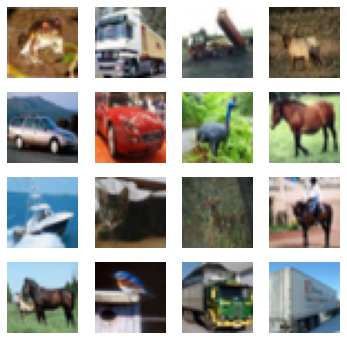

  0%|          | 0/195 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB. GPU  has a total capacity of 23.59 GiB of which 98.19 MiB is free. Process 310682 has 17.18 GiB memory in use. Including non-PyTorch memory, this process has 5.80 GiB memory in use. Of the allocated memory 5.38 GiB is allocated by PyTorch, and 106.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
from typing import Dict

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# Local imports
from unet import UNet
from Scheduler import GradualWarmupScheduler
from funcs import *
from trainer_and_sampler import *

# Ensure necessary directories exist
os.makedirs("Checkpoints", exist_ok=True)
os.makedirs("SampledImgs", exist_ok=True)

# -----------------------------
# Configuration
# -----------------------------
epoch_num = 1000
pre_epoch = 0
cfg = {
    "epoch": epoch_num,
    "batch_size": 256,
    "T": 1000,
    "channel": 128,
    "channel_mult": [1, 2, 3, 4],
    "attn": [2],
    "num_res_blocks": 2,
    "dropout": 0.15,
    "lr": 1e-4,
    "multiplier": 2.,
    "beta_1": 1e-4,
    "beta_T": 0.02,
    "img_size": 32,
    "grad_clip": 1.,
    "dataset_root": '../../data/raw/CIFAR10',
    "device": torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
    "training_load_weight": None,
    "save_weight_dir": "./Checkpoints/",
    "test_load_weight": f"ckpt_{epoch_num - 1}_.pt",
    "sampled_dir": "./SampledImgs/",
    "sampledNoisyImgName": "NoisyNoGuidenceImgs.png",
    "sampledImgName": "SampledNoGuidenceImgs.png",
    "nrow": 8,
    "noise_level": 1.0,
}
print("Using device:", cfg["device"])

# -----------------------------
# Dataset and Visualization
# -----------------------------
dataset = CIFAR10(
    root=cfg["dataset_root"], train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

dataloader = DataLoader(
    dataset, batch_size=cfg["batch_size"], shuffle=True, num_workers=4, drop_last=True, pin_memory=True
)

def plot_dataset_samples(dataset, num_samples=16):
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flatten()):
        image, _ = dataset[i]
        ax.imshow((image.permute(1, 2, 0) + 1) / 2)
        ax.axis("off")
    plt.show()

plot_dataset_samples(dataset)

# -----------------------------
# Model and Optimization Setup
# -----------------------------
device = cfg["device"]
net_model = UNet(T=cfg["T"], ch=cfg["channel"], ch_mult=cfg["channel_mult"],
                 attn=cfg["attn"], num_res_blocks=cfg["num_res_blocks"],
                 dropout=cfg["dropout"]).to(device)

if cfg["training_load_weight"] is not None:
    print("Loading pre-trained weights...")
    net_model.load_state_dict(torch.load(
        os.path.join(cfg["save_weight_dir"], cfg["training_load_weight"]),
        map_location=device))

optimizer = optim.AdamW(net_model.parameters(), lr=cfg["lr"], weight_decay=1e-4)
cosineScheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg["epoch"])
warmUpScheduler = GradualWarmupScheduler(optimizer, multiplier=cfg["multiplier"],
                                          warm_epoch=cfg["epoch"] // 10,
                                          after_scheduler=cosineScheduler)

trainer = GaussianDiffusionTrainer(net_model, cfg["beta_1"], cfg["beta_T"], cfg["T"],
                                    cfg["noise_level"]).to(device)

# -----------------------------
# Training Loop with Loss Tracking
# -----------------------------
training_losses = []

for e in range(pre_epoch, cfg["epoch"]):
    epoch_loss = 0.0
    batch_count = 0

    with tqdm(dataloader, dynamic_ncols=True) as tqdmDataLoader:
        for images, _ in tqdmDataLoader:
            x_0 = images.to(device)
            optimizer.zero_grad()
            loss = trainer(x_0).sum() / 1000.
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net_model.parameters(), cfg["grad_clip"])
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1

            tqdmDataLoader.set_postfix(ordered_dict={
                "epoch": e,
                "loss": loss.item(),
                "img shape": x_0.shape,
                "LR": optimizer.state_dict()['param_groups'][0]["lr"]
            })

    avg_epoch_loss = epoch_loss / batch_count
    training_losses.append(avg_epoch_loss)
    print(f"Epoch {e}: Average Loss = {avg_epoch_loss:.6f}")

    warmUpScheduler.step()

    if e % 100 == 99:
        torch.save(net_model.state_dict(), os.path.join(cfg["save_weight_dir"], f'ckpt_{e}_.pt'))
        print(f"Saved checkpoint at epoch {e}")

# Save loss data
torch.save(training_losses, os.path.join(cfg["save_weight_dir"], "training_losses.pt"))
pd.DataFrame(training_losses, columns=["loss"]).to_csv(
    os.path.join(cfg["save_weight_dir"], "training_losses.csv"), index_label="epoch"
)
